In [69]:
library("dplyr")
library("ggplot2")
library("tidyverse")          
library("rvest")
library("knitr")
library("kableExtra")
library("httr")
library("jsonlite")
library("grid")

In [40]:
strong <- read.csv("strong.csv")
strong <- strong[-c(1:60, 103:109),c(1:2,4:7)]     #ta bort harald och onödinga kolumner
strong$Weight[strong$Weight== 675.0] <- 67.5  #fixa mistag 
strong <- strong[!(strong$Exercise.Name %in% c("Stairclimber", "Rowing (Machine)")), ]  #ta bort uppvärmning
strong$Weight <- ifelse(strong$Exercise.Name == "Pull Up (Assisted)", 55 - strong$Weight, strong$Weight)  #fixa vikt pullup
tot_wo <- length(unique(strong[[1]]))
tot_ex <- length(unique(strong[[3]]))
tot_weight <- round(sum(strong$Weight * strong$Reps),0)

print(paste("Number of Workouts:", tot_wo))
print(paste("Total Weight:", tot_weight, "kg"))
print(paste("Unique Exercises:", tot_ex))

[1] "Number of Workouts: 115"
[1] "Total Weight: 554316 kg"
[1] "Unique Exercises: 23"


In [41]:
strong <- strong %>% separate(Date, into = c("Date", "Time"), sep = " ")
strong$Date <- as.Date(strong$Date, format = "%Y-%m-%d")
strong$Time <- format(strptime(gsub("-", ":", strong$Time), format = "%H:%M:%S"), format = "%H:%M:%S")
strong$Hour <- as.numeric(format(strptime(strong$Time, format = "%H:%M:%S"), "%H"))
strong <- strong %>% mutate(Group = ifelse(Hour <= 13, "before lunch", "after lunch"))

In [42]:
wo_distribution <- strong %>%
  mutate(Month = as.Date(cut(Date, breaks = "month"))) %>%
  group_by(Month, Group) %>%
  summarise(wo = n_distinct(Date))

plot1 <- ggplot(wo_distribution, aes(x = Month, y = wo, fill = Group)) +
  geom_bar(stat = "identity") +
  scale_x_date(date_labels = "%b", date_breaks = "1 month") +
  labs(title = "Workouts per Month",
       x = "Month",
       y = "Number of Workouts",
       fill = "Time of day", 
       caption = "Figure 1: Workouts per month in 2024 from january 17 to december 21.") +
  theme_minimal() +
  scale_fill_manual(values = c("after lunch" = "thistle", "before lunch" = "lightsteelblue")) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), plot.title = element_text(hjust = 0.5))


time_distribution <- strong %>%
  distinct(Date, .keep_all = TRUE) %>% 
  mutate(Hour = substr(Time, 1, 2)) %>% 
  group_by(Hour) %>%
  summarise(Count = n()) 

plot2 <- ggplot(time_distribution, aes(x = Hour, y = Count)) +
  geom_bar(stat = "identity", fill = "lightsteelblue") +
  labs(title = "Time Distribution of Workouts",
       x = "Hour",
       y = "Workouts", 
       caption = "Figure 2: Time of day for workouts in 2024 from january 17 to december 21.") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), plot.title = element_text(hjust = 0.5))

`summarise()` has grouped output by 'Month'. You can override using the
`.groups` argument.


In [43]:
strong_avg <- strong %>%
  group_by(Date, Time, Exercise.Name, Group) %>%       
  arrange(desc(Weight), .by_group = TRUE) %>%     
  slice_head(n = 3) %>%                          
  summarize(Avg_Weight = mean(Weight), Avg_Reps = mean(Reps)) %>%
  mutate(score = round(Avg_Weight * log(Avg_Reps), 0)) %>% 
  ungroup()

average_scores_by_group <- strong_avg %>%
  group_by(Group, Exercise.Name) %>%
  summarise(Average_Score = mean(score, na.rm = TRUE))

wilcox_test_result <- wilcox.test(
  Average_Score ~ Group,
  data = average_scores_by_group,
  alternative = "two.sided",
  exact = FALSE)

print(paste("P-value of Wilcox test:", round(wilcox_test_result$p.value, 3)))

`summarise()` has grouped output by 'Date', 'Time', 'Exercise.Name'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'Group'. You can override using the
`.groups` argument.


[1] "P-value of Wilcox test: 0.733"


In [44]:
exercise_counts <- strong_avg %>%
  group_by(Exercise.Name) %>%      
  tally() %>%     
  arrange(desc(n)) 

top_exercises <- exercise_counts$Exercise.Name[1:6]
bottom_exercises <- exercise_counts$Exercise.Name[7:17]

strong_top <- strong_avg %>%
  filter(Exercise.Name %in% top_exercises) 

strong_bottom <- strong_avg %>%
  filter(Exercise.Name %in% bottom_exercises) 

plot3 <- ggplot(strong_top, aes(x = Date, y = score, color = Exercise.Name, group = Exercise.Name)) + 
  geom_line() + 
  geom_point() + 
  labs(title = "Exercise Score Over Time",
    x = "Date",
    y = "Score",
    color = "Exercise",
    caption = "Figure 3: Progress of top 6 most popular exercises in 2024") +
  theme_minimal() +  
  theme(axis.text.x = element_text(angle = 45, hjust = 1),legend.position = "bottom", plot.title = element_text(hjust = 0.5)) +
  scale_x_date(date_labels = "%b", date_breaks = "1 month")

plot4 <- ggplot(strong_bottom, aes(x = Date, y = score, color = Exercise.Name, group = Exercise.Name)) + 
  geom_line() + 
  geom_point() + 
  labs(title = "Exercise Score Over Time",
    x = "Date",
    y = "Score",
    color = "Exercise",
    caption = "Figure 4: Progress of exercises in 2024") +
  theme_minimal() +  
  theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position = "bottom", plot.title = element_text(hjust = 0.5)) +
  scale_x_date(date_labels = "%b", date_breaks = "1 month")+
  guides(color = guide_legend(ncol = 3)) 

In [45]:
top_10 <- strong_avg %>% 
  group_by(Exercise.Name) %>%
  summarise(first_avg = mean(score[1:3], na.rm = TRUE), last_avg = mean(tail(score, 3), na.rm = TRUE)) %>%
  mutate(Increase = 100*(last_avg-first_avg)/first_avg) %>%
  arrange(desc(Increase)) %>%
  head(10)

top_10$Increase <- paste(round(top_10$Increase), "%")
colnames(top_10) <- c("Exercise","First Avrage" ,"Last Avrage" , "Increase")

table1 <- top_10[1:10,c(1,4)]%>%                                        
  kable("html", caption = "Table 1: Top 10 exercises with largest score increase.", escape = FALSE) %>%
  kable_styling(full_width = TRUE, position = "left", bootstrap_options = c("striped")) %>% 
  row_spec(0, background = "darkgoldenrod2", bold = TRUE, color = "white") %>%
  row_spec(c(2,4,6,8,10), background = "lavenderblush") %>%
  row_spec(c(1,3,5,7,9), background = "lightyellow")

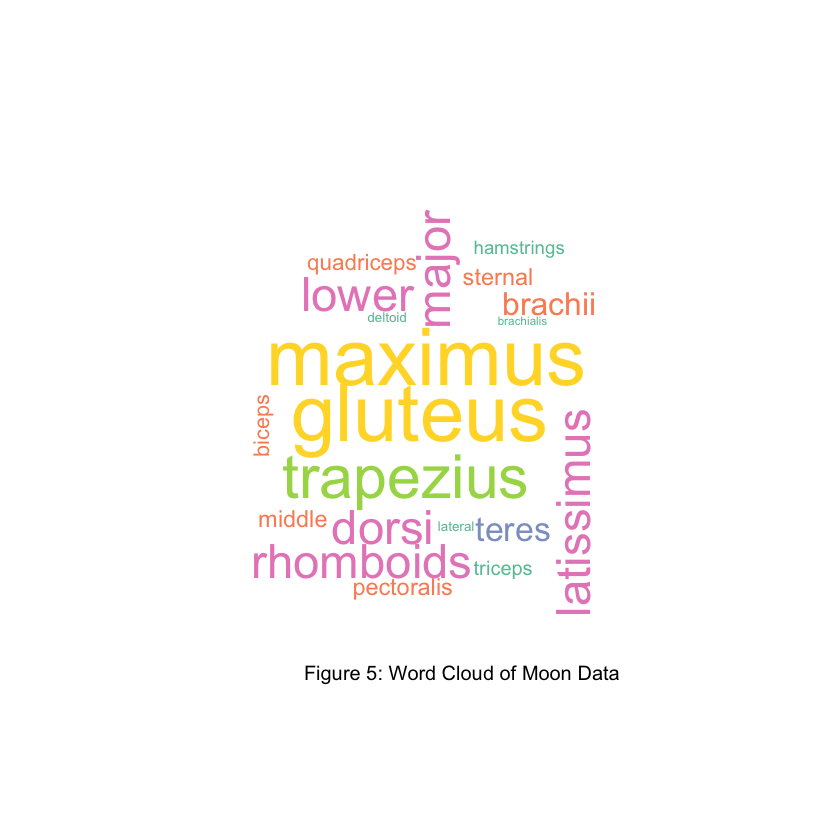

In [68]:
set.seed(20010822)
exercises <- read.csv("gym_exercise_dataset.csv") #https://www.kaggle.com/datasets/rishitmurarka/gym-exercises-dataset?utm_source=chatgpt.com
my_exercises <- as.data.frame(cbind(unique(strong_avg$Exercise.Name),exercises
                      [c(266,128,208,179,92,550,237,338,385,342,339,345,337,501,100,382,132,544,277,338,53,177,396),9]))
colnames(my_exercises) <- c("Exercise.Name", "Target_Muscles")
strong_muscles <- merge(strong_avg, my_exercises, by = "Exercise.Name")

mooncloud <- Corpus(VectorSource(strong_muscles$Target_Muscles))         
mooncloud <- suppressWarnings(tm_map(mooncloud, stripWhitespace))   
mooncloud <- suppressWarnings(tm_map(mooncloud, content_transformer(tolower))) 
mooncloud <- suppressWarnings(tm_map(mooncloud, removePunctuation))   
mooncloud <- suppressWarnings(tm_map(mooncloud, removeWords, stopwords("english")))

wordcloud(mooncloud
        , scale=c(4,0.5)    
        , max.words=100  
        , min.freq = 3
        , random.order=FALSE
        , rot.per=0.25 
        , use.r.layout=TRUE
        , colors=brewer.pal(6, "Set2"))

grid.text("Figure 5: Word Cloud of Moon Data", 
          x = 0.55, y = 0.2, 
          gp = gpar(fontsize = 12, col = "black"))